In [2]:
import pandas as pd
import numpy as np
from transformers import pipeline
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [100]:
news_df = pd.read_csv('data/finnhub_news.csv')

In [103]:
news_df['date'] = pd.to_datetime(news_df['date'])

# Sort the DataFrame by date
news_df_sorted = news_df.sort_values('date')

# Reset the index after sorting (optional)
news_df_sorted = news_df_sorted.reset_index(drop=True)

# If you want to save back to CSV
# news_df_sorted.to_csv('path/to/sorted_file.csv', index=False)

# Display the first few rows to verify
print(news_df_sorted.head())
print(news_df_sorted.tail())

        date symbol                                           headline  \
0 2024-10-30    BAC  These Are The Best Robinhood Stocks To Buy Or ...   
1 2024-10-31    CAT  Analysts Have Conflicting Sentiments on These ...   
2 2024-10-31    CAT  Caterpillar Q3 Miss Shows 'Just a Glimpse" Int...   
3 2024-10-31    CAT  Caterpillar Reports Mixed Q3 2024 Financial Re...   
4 2024-10-31    CAT  Caterpillar Moves Up In Market Cap Rank, Passi...   

                                             summary               source  \
0  These Are The Best Robinhood Stocks To Buy Or ...             DowJones   
1  Looking for stock market analysis and research...             TipRanks   
2  Caterpillar Q3 Miss Shows 'Just a Glimpse" Int...                Yahoo   
3  Caterpillar ( (CAT) ) has shared an announceme...                Yahoo   
4  Looking for stock market analysis and research...  The Online Investor   

                                                 url  summary_sentiment  \
0  https://finnhu

In [14]:
pipe = pipeline("text-classification", model="ProsusAI/finbert")

Device set to use mps:0


In [102]:
# Convert summaries to list first, then process each with FinBERT
summaries = news_df['summary'].fillna('').astype(str).tolist()

# Create lists to store sentiment scores and labels
sentiment_scores = []
sentiment_labels = []

# Process each summary individually
for summary in summaries:
    result = pipe.predict(summary)[0]
    label = result['label']
    score = result['score']
    
    # Store the label
    sentiment_labels.append(label)
    
    # Calculate the modified score based on label
    if label == 'positive':
        sentiment_scores.append(score)
    elif label == 'negative':
        sentiment_scores.append(score * -1)
    else:  # neutral
        sentiment_scores.append(score / 10)

# Add both the scores and labels to the DataFrame
news_df['summary_sentiment'] = sentiment_scores
news_df['sentiment_label'] = sentiment_labels

In [104]:
# Convert headlines to list first, then process each with FinBERT
headlines = news_df['headline'].fillna('').astype(str).tolist()

# Create lists to store sentiment scores and labels
headline_sentiment_scores = []
headline_sentiment_labels = []

# Process each headline individually
for headline in headlines:
    result = pipe.predict(headline)[0]
    label = result['label']
    score = result['score']
    
    # Store the label
    headline_sentiment_labels.append(label)
    
    # Calculate the modified score based on label
    if label == 'positive':
        headline_sentiment_scores.append(score)
    elif label == 'negative':
        headline_sentiment_scores.append(score * -1)
    else:  # neutral
        headline_sentiment_scores.append(score / 10)

# Add both the scores and labels to the DataFrame
news_df['headline_sentiment'] = headline_sentiment_scores
news_df['headline_sentiment_label'] = headline_sentiment_labels

In [16]:
def analyze_sentiment(df, col_name, pipe, suffix=''):
    """
    Analyze sentiment of text in a DataFrame column using FinBERT.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the text column to analyze
    col_name : str
        Name of the column containing text to analyze
    pipe : pipeline
        The FinBERT sentiment analysis pipeline
    suffix : str, optional
        Suffix to add to the new column names (default: '')
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with added sentiment score and label columns
    """
    # Create a copy of the DataFrame to avoid modifying the original
    result_df = df.copy()
    
    # Convert column to list first, then process each with FinBERT
    texts = result_df[col_name].fillna('').astype(str).tolist()
    
    # Create lists to store sentiment scores and labels
    sentiment_scores = []
    sentiment_labels = []
    
    # Process each text individually
    for text in texts:
        prediction = pipe.predict(text)[0]
        label = prediction['label']
        score = prediction['score']
        
        # Store the label
        sentiment_labels.append(label)
        
        # Calculate the modified score based on label
        if label == 'positive':
            sentiment_scores.append(score)
        elif label == 'negative':
            sentiment_scores.append(score * -1)
        else:  # neutral
            sentiment_scores.append(score / 10)
    
    # Add both the scores and labels to the DataFrame
    result_df[f'{col_name}_sentiment{suffix}'] = sentiment_scores
    result_df[f'{col_name}_sentiment_label{suffix}'] = sentiment_labels
    
    return result_df

In [106]:
news_df['date']

0      2025-02-20
1      2025-02-20
2      2025-02-20
3      2025-02-20
4      2025-02-20
          ...    
3597   2024-12-23
3598   2024-12-23
3599   2024-12-22
3600   2024-12-22
3601   2024-12-22
Name: date, Length: 3602, dtype: datetime64[ns]

In [108]:
# First, let's examine the date distribution in the original DataFrame
print("Date value counts:")
print(news_df['date'].value_counts().head(10))

# Check data types and potential issues
print("\nDate column data type:", news_df['date'].dtype)
print("Number of unique dates:", news_df['date'].nunique())
print("Date range:", news_df['date'].min(), "to", news_df['date'].max())

# Ensure dates are in the correct format
# Convert the date column to datetime if it's not already
news_df['date'] = pd.to_datetime(news_df['date'])

# Filter to our expected date range (2025-01-15 to 2025-02-20)
filtered_news_df = news_df[
    (news_df['date'] >= '2024-12-22') & 
    (news_df['date'] <= '2025-02-20')
]

print("\nAfter filtering:")
print("Number of rows:", len(filtered_news_df))
print("Number of unique dates:", filtered_news_df['date'].nunique())
print("Date range:", filtered_news_df['date'].min(), "to", filtered_news_df['date'].max())

# Now create daily sentiment with the filtered data
daily_sentiment_df = filtered_news_df.groupby(filtered_news_df['date'].dt.date).agg({
    'summary_sentiment': 'mean',
    'headline_sentiment': 'mean'
}).reset_index()

# Rename columns for clarity
daily_sentiment_df = daily_sentiment_df.rename(columns={
    'summary_sentiment': 'avg_summary_sentiment',
    'headline_sentiment': 'avg_headline_sentiment'
})

# Calculate overall average sentiment
daily_sentiment_df['avg_overall_sentiment'] = (
    daily_sentiment_df['avg_summary_sentiment'] + 
    daily_sentiment_df['avg_headline_sentiment']
) / 2

print("\nDaily sentiment DataFrame:")
print("Shape:", daily_sentiment_df.shape)
print(daily_sentiment_df.head())

Date value counts:
date
2025-02-05    194
2025-02-19    181
2025-02-10    169
2025-02-18    161
2025-02-14    159
2025-02-13    155
2025-02-11    144
2025-02-20    141
2025-02-07    139
2025-01-15    136
Name: count, dtype: int64

Date column data type: datetime64[ns]
Number of unique dates: 108
Date range: 2024-10-30 00:00:00 to 2025-02-20 00:00:00

After filtering:
Number of rows: 3438
Number of unique dates: 61
Date range: 2024-12-22 00:00:00 to 2025-02-20 00:00:00

Daily sentiment DataFrame:
Shape: (61, 4)
         date  avg_summary_sentiment  avg_headline_sentiment  \
0  2024-12-22              -0.045905                0.150820   
1  2024-12-23               0.175204                0.122033   
2  2024-12-24               0.269969                0.093486   
3  2024-12-25               0.106459               -0.006229   
4  2024-12-26               0.362945                0.230899   

   avg_overall_sentiment  
0               0.052458  
1               0.148619  
2               0.

In [109]:
daily_sentiment_df

,date,avg_summary_sentiment,avg_headline_sentiment,avg_overall_sentiment
0,2024-12-22,-0.045905,0.150820,0.052458
1,2024-12-23,0.175204,0.122033,0.148619
2,2024-12-24,0.269969,0.093486,0.181727
3,2024-12-25,0.106459,-0.006229,0.050115
4,2024-12-26,0.362945,0.230899,0.296922
...,...,...,...,...
56,2025-02-16,0.341609,0.175258,0.258433
57,2025-02-17,-0.144072,0.069026,-0.037523
58,2025-02-18,-0.120998,0.135240,0.007121
59,2025-02-19,0.127132,0.101055,0.114094


In [130]:
start_date = "2024-12-20"
end_date = "2025-02-21"

# Download VIX data
vix_data = yf.download("^VIX", start=start_date, end=end_date)


# Extract needed columns
vix_df = vix_data[["Open", "High", "Low", "Close", "Volume"]].copy()

# Convert index to a date column and reset index
vix_df["date"] = vix_df.index.date
vix_df = vix_df.reset_index(drop=True)

# Reorder columns to have date first
vix_df = vix_df[["date", "Open", "High", "Low", "Close", "Volume"]]

vix_df = vix_df[['date', 'Close']]
print(vix_df.head())
print(vix_df.tail())

[*********************100%***********************]  1 of 1 completed

Price         date      Close
Ticker                   ^VIX
0       2024-12-20  18.360001
1       2024-12-23  16.780001
2       2024-12-24  14.270000
3       2024-12-26  14.730000
4       2024-12-27  15.950000
Price         date  Close
Ticker               ^VIX
35      2025-02-13  15.10
36      2025-02-14  14.77
37      2025-02-18  15.35
38      2025-02-19  15.27
39      2025-02-20  15.66


In [132]:
vix_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in vix_df.columns]

print(vix_df.columns.tolist())


['date_', 'Close_^VIX']


In [133]:
vix_df = vix_df[[ 'date_', 'Close_^VIX']].copy()
vix_df.columns = [ 'date', 'vix_close']


In [136]:
# Ensure date columns are datetime format
daily_sentiment_df['date'] = pd.to_datetime(daily_sentiment_df['date'])
vix_df['date'] = pd.to_datetime(vix_df['date'])

# Sort both dataframes by date
daily_sentiment_df = daily_sentiment_df.sort_values('date')
vix_df = vix_df.sort_values('date')

# Use merge_asof with direction='forward' to match each sentiment row to the next VIX trading day
merged_df = pd.merge_asof(
    daily_sentiment_df,
    vix_df,
    on='date',
    direction='forward'
)

# Rename vix_close to vix_target
merged_df = merged_df.rename(columns={'vix_close': 'vix_target'})

# Drop any rows with missing values
merged_df = merged_df.dropna()

# Display the first few rows
print(merged_df.head())
print(merged_df.tail())

        date  avg_summary_sentiment  avg_headline_sentiment  \
0 2024-12-22              -0.045905                0.150820   
1 2024-12-23               0.175204                0.122033   
2 2024-12-24               0.269969                0.093486   
3 2024-12-25               0.106459               -0.006229   
4 2024-12-26               0.362945                0.230899   

   avg_overall_sentiment  vix_target  
0               0.052458   16.780001  
1               0.148619   16.780001  
2               0.181727   14.270000  
3               0.050115   14.730000  
4               0.296922   14.730000  
         date  avg_summary_sentiment  avg_headline_sentiment  \
56 2025-02-16               0.341609                0.175258   
57 2025-02-17              -0.144072                0.069026   
58 2025-02-18              -0.120998                0.135240   
59 2025-02-19               0.127132                0.101055   
60 2025-02-20               0.015631               -0.051058   

  

In [137]:
merged_df.corr()

,date,avg_summary_sentiment,avg_headline_sentiment,avg_overall_sentiment,vix_target
date,1.000000,-0.208220,-0.136070,-0.203789,-0.257432
avg_summary_sentiment,-0.208220,1.000000,0.526866,0.920513,-0.089386
avg_headline_sentiment,-0.136070,0.526866,1.000000,0.817072,-0.090617
avg_overall_sentiment,-0.203789,0.920513,0.817072,1.000000,-0.102288
vix_target,-0.257432,-0.089386,-0.090617,-0.102288,1.000000


<Axes: xlabel='date'>

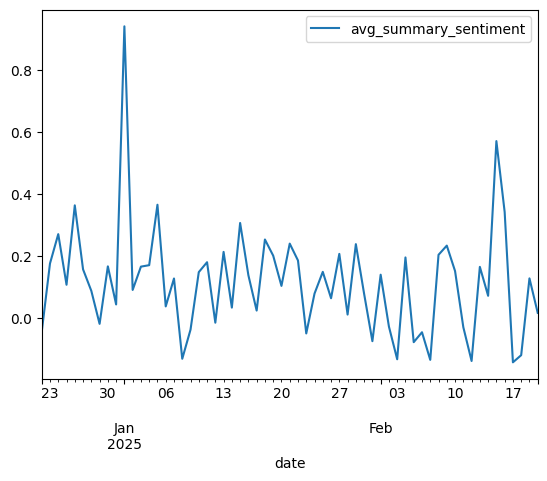

In [138]:
merged_df.plot(x='date', y='avg_summary_sentiment', kind='line')

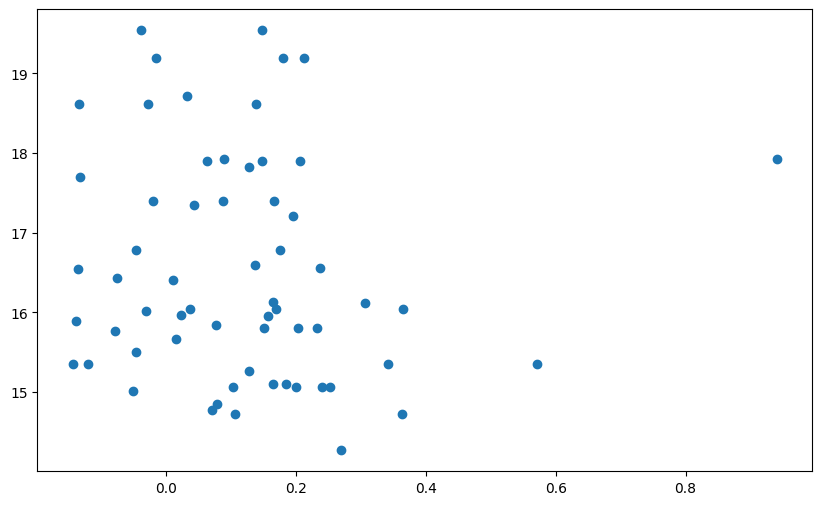

In [148]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(merged_df['avg_summary_sentiment'], merged_df['vix_target'])



In [13]:
macro_df = pd.read_csv('./../vix_news.csv')
macro_df['date'] = pd.to_datetime(macro_df['published_at'])


macro_df['date'] = macro_df['date'].dt.date

macro_df.drop(columns=['published_at'], inplace=True)
macro_df = macro_df.sort_values('date')
macro_df = macro_df.reset_index(drop=True)
macro_df.head()



,topic,title,description,source,date
0,geopolitical tensions,Navigating the CapCut ban: Embracing Wondersha...,"In recent months, the digital landscape has ex...",cyprus-mail,2025-03-21
1,geopolitical tensions,Starlink in Yemen: A digital revolution or a s...,"Starlink brings high-speed internet to Yemen, ...",globalvoicesonline,2025-03-21
2,geopolitical tensions,Chile Leaves Interest Rate at 5%,"The Central Bank of Chile, in its March sessio...",forextv,2025-03-23
3,geopolitical tensions,Italy’s talks with Musk’s Starlink have stalled,Italy’s talks with Musk’s Starlink have stalle...,di-ve,2025-03-24
4,geopolitical tensions,EU urges households to prepare emergency kits ...,As geopolitical tensions grow and climate thre...,euroweeklynews,2025-03-26


In [17]:
macro_df = analyze_sentiment(macro_df, 'description', pipe, '_macro')

In [19]:
macro_df = analyze_sentiment(macro_df, 'title', pipe, '_macro')

In [20]:
macro_df.head()

,topic,title,description,source,date,description_sentiment_macro,description_sentiment_label_macro,title_sentiment_macro,title_sentiment_label_macro
0,geopolitical tensions,Navigating the CapCut ban: Embracing Wondersha...,"In recent months, the digital landscape has ex...",cyprus-mail,2025-03-21,-0.494532,negative,0.087493,neutral
1,geopolitical tensions,Starlink in Yemen: A digital revolution or a s...,"Starlink brings high-speed internet to Yemen, ...",globalvoicesonline,2025-03-21,0.086038,neutral,0.090653,neutral
2,geopolitical tensions,Chile Leaves Interest Rate at 5%,"The Central Bank of Chile, in its March sessio...",forextv,2025-03-23,-0.931157,negative,0.090591,neutral
3,geopolitical tensions,Italy’s talks with Musk’s Starlink have stalled,Italy’s talks with Musk’s Starlink have stalle...,di-ve,2025-03-24,-0.888789,negative,-0.569486,negative
4,geopolitical tensions,EU urges households to prepare emergency kits ...,As geopolitical tensions grow and climate thre...,euroweeklynews,2025-03-26,0.081078,neutral,0.558172,positive
